In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers

import jax.numpy as jnp
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('AAPL_smooth_0.8.csv', index_col=0)
df.head()

,Timestamp,Date,Close,Volume,Open,High,Low,Vwap,MACD Value,Signal,RSI Value,Williams %R,%K,%D,%J
0,1612846800000,2021-02-09,133.218918,7.593188e+07,133.572703,134.713662,132.735875,133.608111,1.492711,1.642579,56.674584,-75.576602,24.423398,24.423398,24.423398
1,1612933200000,2021-02-10,132.598959,7.362366e+07,133.522739,134.150061,131.727580,132.642879,1.353033,1.584670,47.644207,-70.818643,26.802377,25.612888,29.181357
2,1613019600000,2021-02-11,132.271525,6.614873e+07,133.058869,133.567808,131.032923,132.157057,1.207893,1.509314,42.576877,-66.349091,29.085221,26.770332,33.715000
3,1613106000000,2021-02-12,132.393844,6.134583e+07,131.753077,132.778318,130.831374,131.928785,1.099142,1.427280,32.966785,-59.753893,34.359458,30.082352,42.913669
4,1613451600000,2021-02-16,130.712265,7.673021e+07,132.384077,132.996064,130.086727,131.080979,0.831293,1.308083,29.221441,-86.480508,29.138836,30.861172,25.694165


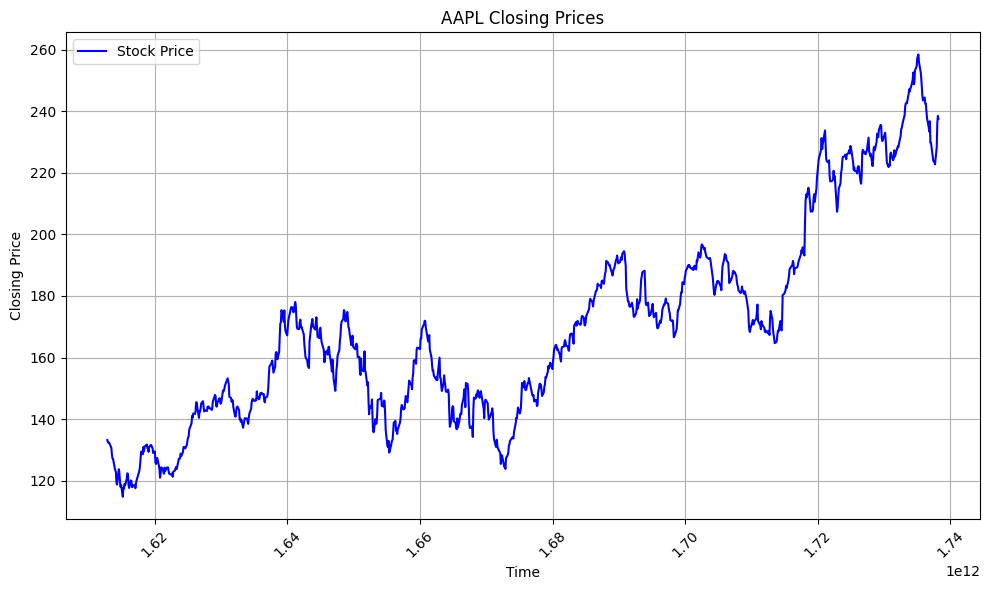

In [3]:
# Plotting the closing prices
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Close'], color = 'blue', label = 'Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.title('AAPL Closing Prices')
plt.tight_layout()
plt.show()

# **Data Processing**


In [23]:
# Put closing prices into numpy array
closing_prices = df['Close'].values.reshape(-1, 1)

# Normalize the data between [0,1]
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(closing_prices)

In [5]:
# function for creating sequences to feed into model
def create_training_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
        y.append(data[i + window_size, 0])       # closing price in day after the x-sequence
    return np.array(X), np.array(y)

In [6]:
# Define training and validation sizes
train_size = int(len(df) * 0.7)
val_size = len(df) - train_size

# Split into training and validation sets
train, val = scaled_data[: train_size, :], scaled_data[train_size:, :]

# Using the data sets, create sequences to feed into model
window_size = 60
X_train, y_train = create_training_sequences(train, window_size)
X_val, y_val = create_training_sequences(val, window_size)

# **Model Construction and Training**

In [7]:
model = keras.Sequential([
    layers.LSTM(32, return_sequences = True, input_shape = (X_train.shape[1], 1)),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 32)              │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,761 (53.75 KB)

 Trainable params: 13,761 (53.75 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = 50, validation_data=(X_val, y_val))


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0795 - val_loss: 0.0201
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0132 - val_loss: 0.0574
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0089 - val_loss: 0.0380
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0068 - val_loss: 0.0174
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

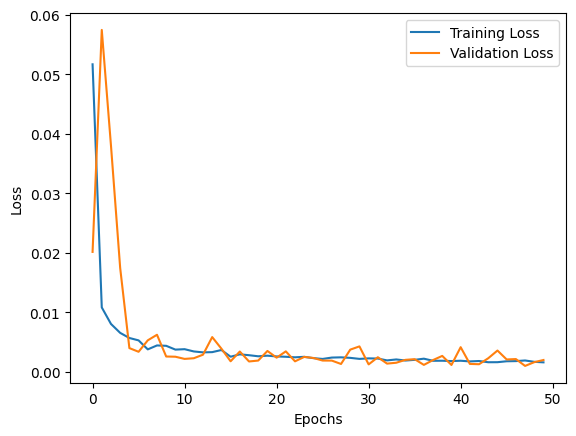

In [10]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Visualizing Performance on Training and Validation Data**

In [11]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


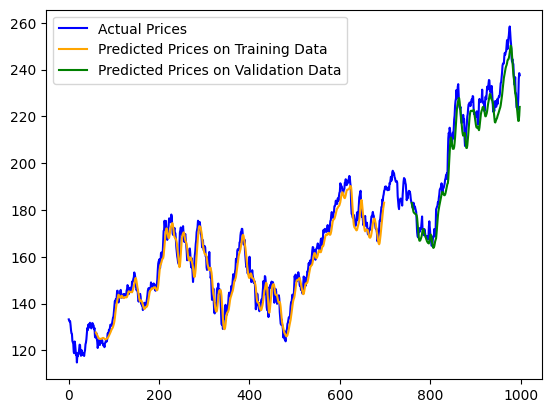

In [12]:
train_predict_plot = np.empty_like(closing_prices)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size :len(train_predict) + window_size, :] = train_predict

# shift test predictions for plotting
test_predict_plot = np.empty_like(closing_prices)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2): len(closing_prices), :] = test_predict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled_data), color = 'blue', label = 'Actual Prices')
plt.plot(train_predict_plot, color = 'orange', label = 'Predicted Prices on Training Data')
plt.plot(test_predict_plot, color = 'green', label = 'Predicted Prices on Validation Data')
plt.legend()
plt.show()

# Performance on Unsmoothed Data

In [13]:
# modified version of create_training_sequences. Only outputs X array, not y array
def create_sequences(data, window_size):
    """
      Returns a list of windows in data of length window_size
          and a list containing corresponding to the data value immediately proceeding a window

      :param data: a numpy array of shape (n, 1), e.g. closing_prices
      :param window_size: length of window
    """

    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data[i: i + window_size, 0])    # closing prices in last (seq_length)-days
    return np.array(X)

In [14]:
# reading data
df = pd.read_csv('AAPL_unsmooth_0.8.csv')
closing_prices = df['Close'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(closing_prices)

In [15]:
# formatting data to be fed into model
window_size = 60
X_full = create_sequences(scaled_data, window_size)

# getting predictions
full_predict = model.predict(X_full)
full_predict = scaler.inverse_transform(full_predict)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [16]:
# Plotting real vs predicted prices
known_plot = np.empty((closing_prices.shape[0] + 1, 1))
known_plot[:, :] = np.nan
known_plot[:closing_prices.shape[0], :] = closing_prices

prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
prediction_plot[:, :] = np.nan
prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

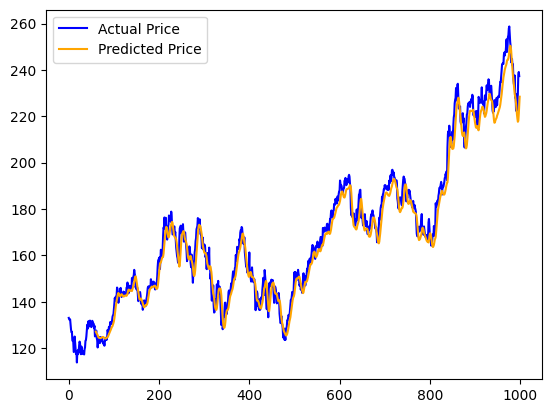

In [17]:
# plot baseline and predictions
plt.plot(known_plot, color = 'blue', label = 'Actual Price')
plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
plt.legend()
plt.show()

#**Performance on Different Stocks**

In [18]:
tickers = ['CMG', 'GOOGL', 'MSFT', 'NFLX', 'NVDA', 'OPK']

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


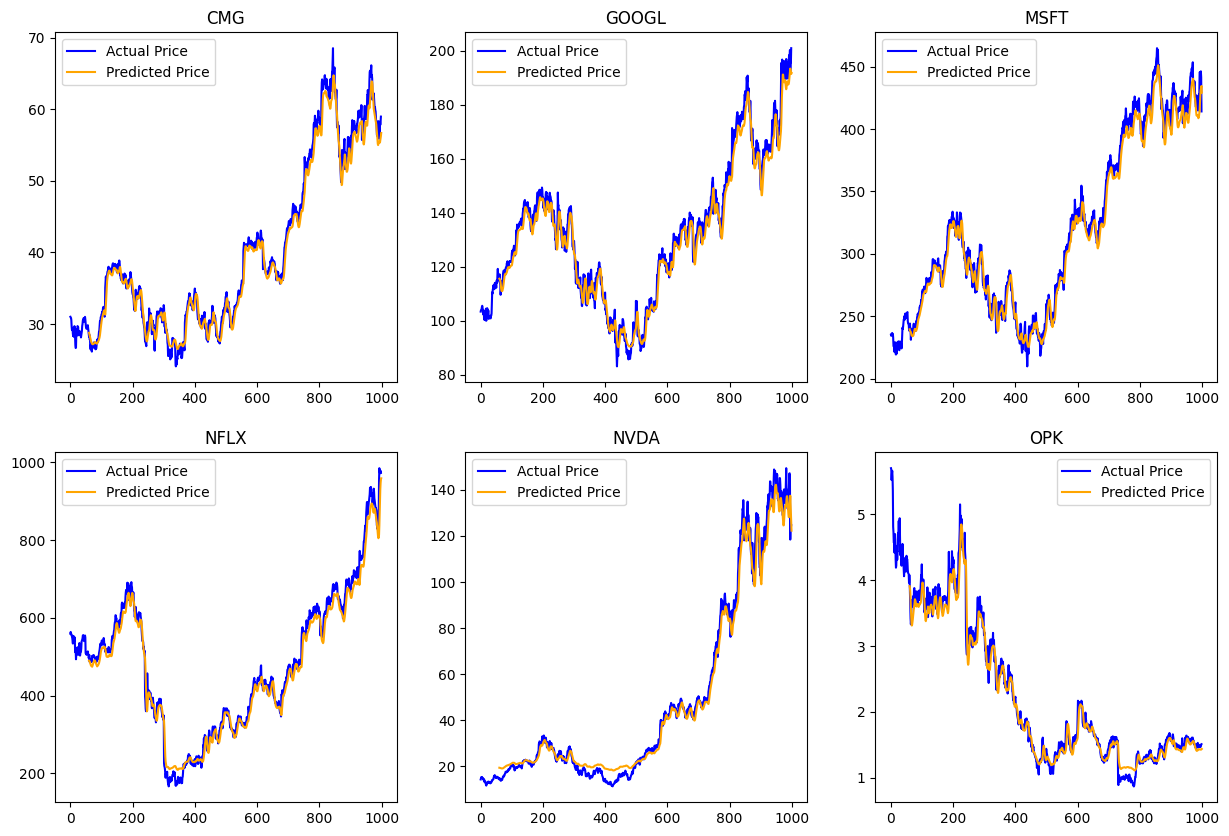

In [19]:
plt.figure(figsize = (15,10))
for i in range(6):
  # reading data
  df = pd.read_csv(f'{tickers[i]}_unsmooth_0.8.csv')
  closing_prices = df['Close'].values.reshape(-1, 1)
  scaled_data = scaler.fit_transform(closing_prices)

  # formatting data to be fed into model
  window_size = 60
  X_full = create_sequences(scaled_data, window_size)

  # getting predictions
  full_predict = model.predict(X_full)
  full_predict = scaler.inverse_transform(full_predict)

  # Plotting real vs predicted prices
  known_plot = np.empty((closing_prices.shape[0] + 1, 1))
  known_plot[:, :] = np.nan
  known_plot[:closing_prices.shape[0], :] = closing_prices

  prediction_plot = np.empty((closing_prices.shape[0] + 1, 1))
  prediction_plot[:, :] = np.nan
  prediction_plot[window_size: closing_prices.shape[0] + 1, :] = full_predict

  # set up subplots
  plt.subplot(2,3,i+1)
  plt.title(f'{tickers[i]}')
  plt.plot(known_plot, color = 'blue', label = 'Actual Price')
  plt.plot(prediction_plot, color = 'orange', label = 'Predicted Price')
  plt.legend()

plt.show()

# **Applying the Model for Forecasting**

In [20]:
# reading data
df = pd.read_csv('AAPL_smooth_0.8.csv', index_col=0)

# normalizing
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [21]:
# obtaining one prediction
X_one = create_sequences(scaled_data[:60], window_size)
one_predict = model.predict(X_one)
one_predict = scaler.inverse_transform(one_predict)
one_predict[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


127.62762

In [22]:
# define forecast window size
days_forward = 60

# initialize array to store future values
forecast_df = np.empty(days_forward, )

# get predictions
for i in range(days_forward):
  seq = create_sequences(scaled_data[:60+i], window_size)
  one_predict = model.predict(seq, verbose = 0)
  one_predict = scaler.inverse_transform(one_predict)
  forecast_df[i] = one_predict[0][0]